# Demo

XGBoost with 1D-CNN for dimensionality reduction for simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

import dataloader
import models
import util

In [2]:
Bakken = dataloader.DataLoader(verbose=False)
x_train, x_test, y_train, y_test, y_cumm_train, y_cumm_test = Bakken.get_data_split()

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, y_cumm_train.shape, y_cumm_test.shape)

(480, 6) (120, 6) (480, 60, 3) (120, 60, 3) (480,) (120,)


# Display input and output data

(600, 6)
(600, 60, 3)


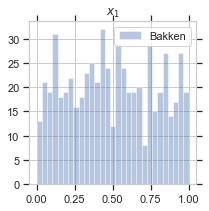

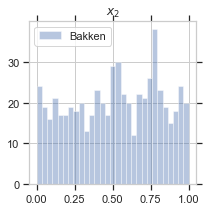

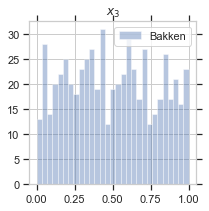

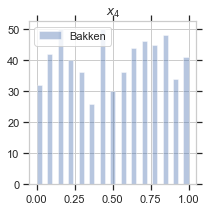

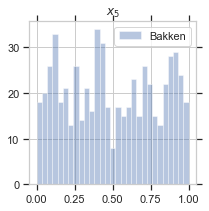

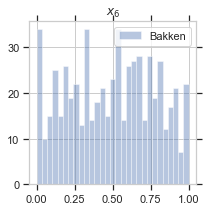

In [3]:
#field data: input and output data to plot
print(Bakken.x.shape)
print(Bakken.y.shape)

col_names = ['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$']
y_lims = [0.0008, 2e-6, 4e-7, 0.0015, 0.1, 0.08]

#function to plot the density plot
def histplot(data1, col_name, y_lim):
    new_bins = np.linspace(np.min(data1), np.max(data1), 30)
    ax = sns.set(style="whitegrid", rc={'figure.figsize':(3, 3)})
    plt.figure()
    sns.distplot(data1, hist=True, bins=new_bins, norm_hist=False, kde=False)
    plt.legend(['Bakken'])
    #plt.ylim([0, y_lim])
    plt.tick_params(axis='both', which='both', bottom='on', top='off', labelbottom='on', right='off', left='on', labelleft='off')
    plt.title(col_name)
    
for idx, feature in enumerate(col_names):
    histplot(Bakken.x[:,idx], feature, y_lims[idx])

Text(0.5, 1.0, 'Water rates')

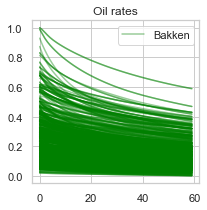

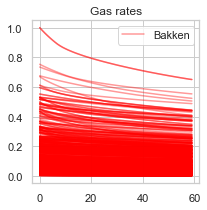

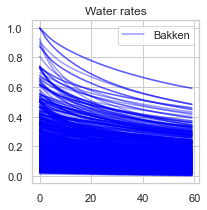

In [4]:
#field data: display the output data

plt.figure(figsize=[3, 3])
for i in range(Bakken.y.shape[0]):
    plt.plot(Bakken.y[i, :, 0], c='green', alpha=0.4)
plt.legend(['Bakken'])
plt.title('Oil rates')

plt.figure(figsize=[3, 3])
for i in range(Bakken.y.shape[0]):
    plt.plot(Bakken.y[i, :, 1], c='red', alpha=0.4)   
plt.legend(['Bakken'])
plt.title('Gas rates')

plt.figure(figsize=[3, 3])
for i in range(Bakken.y.shape[0]):
    plt.plot(Bakken.y[i, :, 2], c='blue', alpha=0.4)
plt.legend(['Bakken'])
plt.title('Water rates')

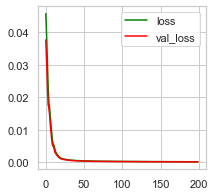

In [5]:
#reduce dimension of data

z_dim = 3
data_ae = models.models(name = 'data_ae',
                          z_dim = z_dim, 
                          timesteps = y_train.shape[1], 
                          n_features = y_train.shape[-1])

data_ae.train_autoencoder1D(y_train, load = False, epoch=200)

In [6]:
#qc reconstruction quality
y_train_hat = data_ae.d2d.predict(y_train)
y_test_hat = data_ae.d2d.predict(y_test)

z_y_train_hat = data_ae.d2zd.predict(y_train)
z_y_test_hat = data_ae.d2zd.predict(y_test)

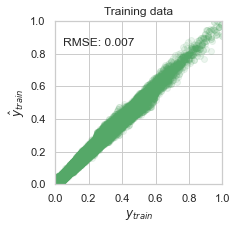

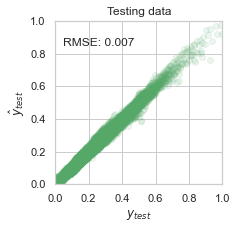

In [7]:
def RMSE(data1, data2):
    return np.sqrt(np.mean((data1.flatten()-data2.flatten())**2)) /2

#scatter plots for training and testing, color by field label
def scatterPlot(data1, data2, xlabel, ylabel, title, limits=True, c=None):
    fig, ax = plt.subplots(figsize=(3, 3))
    if c is None:
        plt.scatter(data1, data2, c='g', alpha=0.1)
    else:
        plt.scatter(data1, data2, c=c, alpha=0.9, cmap="seismic")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if limits:
        plt.xlim([0, 1])
        plt.ylim([0, 1])
    plt.title(title)
    ax.annotate(f"RMSE: {RMSE(data1, data2):.3f}", xy=(0.8, 0.8),  xycoords='data',
            xytext=(0.05, 0.9), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top')
    
scatterPlot(y_train, y_train_hat, '$y_{train}$', '$\hat{y}_{train}$', 'Training data')
scatterPlot(y_test, y_test_hat, '$y_{test}$', '$\hat{y}_{test}$', 'Testing data')

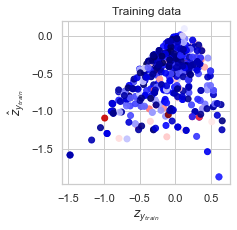

In [8]:
#display latent space with cumm production
scatterPlot(z_y_train_hat[:, 0], z_y_train_hat[:, 1], '$z_{y_{train}}$', '$\hat{z}_{y_{train}}$', 'Training data', limits=False, c=y_cumm_train)

# XGBoost

In [10]:
#data
print(x_train.shape, z_y_train_hat.shape)
print(x_test.shape, z_y_test_hat.shape)

(480, 6) (480, 3)
(120, 6) (120, 3)
